## Import libraries

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import trange
import os, sys, zipfile
import shutil
import urllib.request
import requests
import skimage.io as io
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask
from torchvision import transforms
from utils import decode_segmap
from torch.utils.data import DataLoader
import custom_transforms as tr
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
base_size = 513
crop_size = 513


## Record package versions for reproducibility

In [2]:
print("os: {}".format(os.name))
print("sys: {}".format(sys.version))
print("numpy: {}, {}".format(np.__version__, np.__file__))

os: nt
sys: 3.8.1 (default, Jan  8 2020, 15:55:49) [MSC v.1916 64 bit (AMD64)]
numpy: 1.18.1, C:\Users\bluep\Anaconda3\envs\capstone\lib\site-packages\numpy\__init__.py


## Setup data paths

In [3]:
dataDir = '../coco_dataset'
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)
print(f'annDir: {annDir}')
print(f'annFile: {annFile}')
print(f'annZipFile: {annZipFile}')
print(f'annURL: {annURL}')

annDir: ../coco_dataset/annotations
annFile: ../coco_dataset/annotations/instances_val2017.json
annZipFile: ../coco_dataset/annotations_trainval2017.zip
annURL: http://images.cocodataset.org/annotations/annotations_trainval2017.zip


## Download data if not available locally

In [4]:
if not os.path.exists(annDir):
    os.makedirs(annDir)
if not os.path.exists(annFile):
    if not os.path.exists(annZipFile):
        print("Downloading zipped annotations to " + annZipFile + " ...")
        with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print("... done downloading")
    print("Unzipping " + annZipFile)
    with zipfile.ZipFile(annZipFile, "r") as zip_ref:
        zip_ref.extractall(dataDir)
    print("... done unzipping")
print("will use annotations in " + annFile)

will use annotations in ../coco_dataset/annotations/instances_val2017.json


## Initialize COCO API for instance annotations

In [5]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


## Display COCO categories and supercategories

In [6]:
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
sports person vehicle animal outdoor kitchen food appliance furniture indoor accessory electronic


In [7]:
print(coco.cats)

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'}, 2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, 3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, 4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, 5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, 6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, 7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, 9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, 10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, 11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, 14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, 15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, 16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, 18: {'supercat

##  Get all images containing given categories, for an example

In [8]:
catIds = coco.getCatIds(catNms=['person', 'dog', 'skateboard'])
imgIds = coco.getImgIds(catIds=catIds)
imgs = coco.loadImgs(imgIds[1])
annIds = coco.getAnnIds(imgIds=imgIds[1])
anns = coco.loadAnns(annIds)

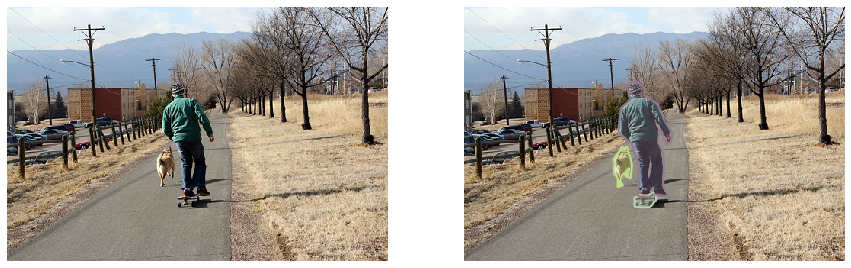

In [9]:
for img in imgs:
    I = io.imread(img['coco_url'])
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))
    ax1.axis('off')
    ax1.imshow(I) 
    ax2.axis('off')
    ax2.imshow(I)    
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
plt.show()

## Download 2017 validation images for simplicity
A size of training images is too large for data exploration

In [10]:
# catIds = coco.getCatIds()
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds)
imgType = 'val2017'
imgDir = '../coco_dataset/{}/'.format(imgType)
if not os.path.exists(imgDir):
    os.makedirs(imgDir)
    for im in imgs:
        img_data = requests.get(im['coco_url']).content
        with open(imgDir + im['file_name'], 'wb') as handler:
            handler.write(img_data)

## Class for COCO dataset

In [11]:
class COCOSegmentation(Dataset):
    NUM_CLASSES = 21
    CAT_LIST = [0, 5, 2, 16, 9, 44, 6, 3, 17, 62, 21, 67, 18, 19, 4,
        1, 64, 20, 63, 7, 72] # set the lower number of classes for a trial

    def __init__(self,
                 base_dir='../coco_dataset',
                 split='train',
                 year='2017'):
        super().__init__()
        ann_file = os.path.join(base_dir, 'annotations/instances_{}{}.json'.format(split, year))
        ids_file = os.path.join(base_dir, 'annotations/{}_ids_{}.pth'.format(split, year))
        self.img_dir = os.path.join(base_dir, '{}{}'.format(split, year))
        self.split = split
        self.coco = COCO(ann_file)
        self.coco_mask = mask
        if os.path.exists(ids_file):
            self.ids = torch.load(ids_file)
        else:
            ids = list(self.coco.imgs.keys())
            self.ids = self._preprocess(ids, ids_file)
        

    def __getitem__(self, index):
        '''
        Make class object to be indexed and apply different transform according to train or validation images
        Args:
            index(integer): index
            
        Return:
            sample(dict): containing images and ground truth after transformation
        '''
        _img, _target = self._make_img_gt_point_pair(index)
        sample = {'image': _img, 'label': _target}

        if self.split == "train":
            return self.transform_tr(sample)
        elif self.split == 'val':
            return self.transform_val(sample)

    def _make_img_gt_point_pair(self, index):
        '''
        Make a pair of image and ground_truth mask
        Args:
            index(integer): index
            
        Return:
            _img(PIL.image): image object for training images
            _target(PIL.image): image object for ground truth masks             
        '''
        coco = self.coco
        img_id = self.ids[index]
        img_metadata = coco.loadImgs(img_id)[0]
        path = img_metadata['file_name']
        _img = Image.open(os.path.join(self.img_dir, path)).convert('RGB')
        cocotarget = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        _target = Image.fromarray(self._gen_seg_mask(
            cocotarget, img_metadata['height'], img_metadata['width']))

        return _img, _target

    def _preprocess(self, ids, ids_file):
        '''
        Preprocess images to generate labels(masks) and filter out images containing label pixels lower than 1000
        Args:
            ids(list): image ids
            ids_file(string): file name to save
            
        Return:
            new_ids(list): image ids after filtering
        '''
        print("Preprocessing mask, this will take a while. " + \
              "But don't worry, it only run once for each split.")
        tbar = trange(len(ids))
        new_ids = []
        for i in tbar:
            img_id = ids[i]
            cocotarget = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
            img_metadata = self.coco.loadImgs(img_id)[0]
            mask = self._gen_seg_mask(cocotarget, img_metadata['height'],
                                      img_metadata['width'])
            # more than 1k pixels
            if (mask > 0).sum() > 1000:
                new_ids.append(img_id)
            tbar.set_description('Doing: {}/{}, got {} qualified images'. \
                                 format(i, len(ids), len(new_ids)))
        print('Found number of qualified images: ', len(new_ids))
        torch.save(new_ids, ids_file)
        return new_ids

    def _gen_seg_mask(self, target, h, w):
        '''
        Generate mask object which contain a label map for each image
        Also change category ids to be aligned with ascending order ex: [0, 5, 2, 16] -> [0, 1, 2, 3]
        Args:
            target(dict): coco annotations
            h(integer): height of an image
            w(integer): width of an image
        
        Return:
            mask(np.array): np.array shape will be (h x w), each element will have a label id 
        '''
        mask = np.zeros((h, w), dtype=np.uint8)
        coco_mask = self.coco_mask
        for instance in target:
            rle = coco_mask.frPyObjects(instance['segmentation'], h, w)
            m = coco_mask.decode(rle)
            cat = instance['category_id']
            if cat in self.CAT_LIST:
                c = self.CAT_LIST.index(cat)
            else:
                continue
            if len(m.shape) < 3:
                mask[:, :] += (mask == 0) * (m * c)
            else:
                mask[:, :] += (mask == 0) * (((np.sum(m, axis=2)) > 0) * c).astype(np.uint8)
        return mask

    def transform_tr(self, sample):
        composed_transforms = transforms.Compose([
            tr.RandomHorizontalFlip(),
            tr.RandomScaleCrop(base_size=base_size, crop_size=crop_size),
            tr.RandomGaussianBlur(),
            tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            tr.ToTensor()])

        return composed_transforms(sample)

    def transform_val(self, sample):

        composed_transforms = transforms.Compose([
            tr.FixScaleCrop(crop_size=crop_size),
            tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            tr.ToTensor()])

        return composed_transforms(sample)


    def __len__(self):
        return len(self.ids)


In [12]:
coco_val = COCOSegmentation(split='val', year='2017')

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


In [13]:
coco_val[1]

{'image': tensor([[[ 1.0331,  1.0331,  1.0331,  ...,  1.1187,  1.1015,  1.1015],
          [ 1.0331,  1.0331,  1.0331,  ...,  1.1187,  1.1015,  1.1015],
          [ 1.0331,  1.0331,  1.0331,  ...,  1.1187,  1.1015,  1.1015],
          ...,
          [ 1.2043,  1.2043,  1.2043,  ..., -0.5938, -0.5082, -0.2342],
          [ 1.2214,  1.2214,  1.2214,  ..., -0.5767, -0.4911, -0.1999],
          [ 1.2214,  1.2214,  1.2214,  ..., -0.5767, -0.4739, -0.1828]],
 
         [[ 1.2031,  1.2031,  1.2031,  ...,  1.2906,  1.2731,  1.2731],
          [ 1.2031,  1.2031,  1.2031,  ...,  1.2906,  1.2731,  1.2731],
          [ 1.2031,  1.2031,  1.2031,  ...,  1.2906,  1.2731,  1.2731],
          ...,
          [ 1.2906,  1.2906,  1.3081,  ..., -0.7927, -0.7052, -0.4251],
          [ 1.3081,  1.3081,  1.3081,  ..., -0.7752, -0.6877, -0.3901],
          [ 1.3081,  1.3081,  1.3081,  ..., -0.7752, -0.6702, -0.3725]],
 
         [[ 1.3328,  1.3328,  1.3328,  ...,  1.5768,  1.5594,  1.5594],
          [ 1.3328,

In [14]:
print(coco_val[0]['image'].shape)
print(coco_val[0]['label'].shape)

torch.Size([3, 513, 513])
torch.Size([513, 513])


In [15]:
dataloader = DataLoader(coco_val, batch_size=4, shuffle=True, num_workers=0)

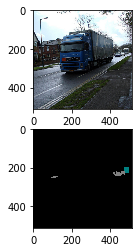

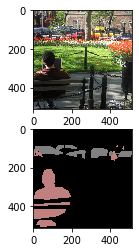

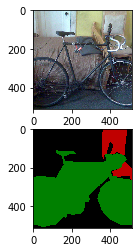

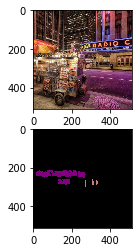

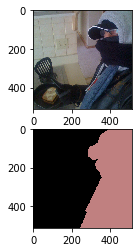

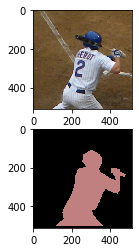

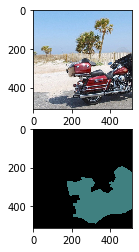

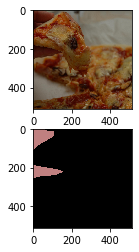

In [16]:
for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img = sample['image'].numpy()
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp)
        img_tmp = np.transpose(img[jj], axes=[1, 2, 0])
        img_tmp *= (0.229, 0.224, 0.225)
        img_tmp += (0.485, 0.456, 0.406)
        img_tmp *= 255.0
        img_tmp = img_tmp.astype(np.uint8)
        plt.figure()
        plt.title('display')
        plt.subplot(211)
        plt.imshow(img_tmp)
        plt.subplot(212)
        plt.imshow(segmap)

    if ii == 1:
        break

plt.show(block=True)